# Fetching breast-histopathology-images dataset from kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

In [ ]:
!ls

In [ ]:
! mkdir data
! unzip breast-histopathology-images.zip -d data

In [7]:
!rm breast-histopathology-images.zip

# Preprocessing data

In [59]:
# import libraries
from glob import glob
import os
from os import listdir
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import keras
# from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import Precision, Recall, TruePositives
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.np_utils import to_categorical
%load_ext tensorboard

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import cv2
from skimage.io import imread
import imblearn
from imblearn.over_sampling import SMOTE

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
base_path = "/content/data/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
print('Number of patients:'+' '+str(len(folder)))

Number of patients: 279


In [4]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0, 1]:    
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

total_images        

277524

In [5]:
# Storing the image_path, patient_id and the target
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,15902,/content/data/IDC_regular_ps50_idx5/15902/0/15...,0
1,15902,/content/data/IDC_regular_ps50_idx5/15902/0/15...,0
2,15902,/content/data/IDC_regular_ps50_idx5/15902/0/15...,0
3,15902,/content/data/IDC_regular_ps50_idx5/15902/0/15...,0
4,15902,/content/data/IDC_regular_ps50_idx5/15902/0/15...,0


In [5]:
data.target = data.target.astype(np.int)

pos_selection = np.random.choice(data[data.target==1].index.values, size=5, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=5, replace=False)

Some healthy samples:

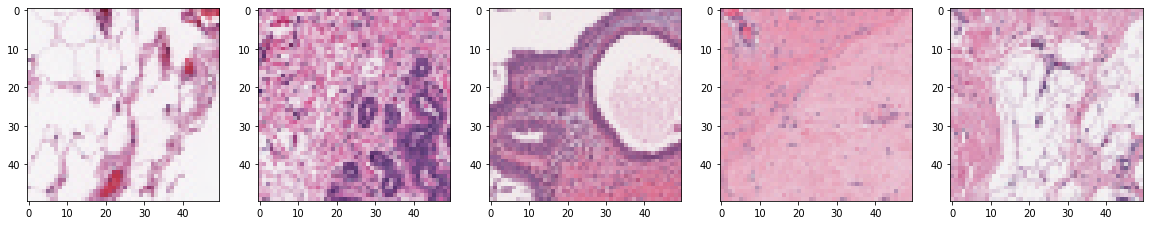

In [6]:
fig, ax = plt.subplots(1,5,figsize=(20,10))

for m in range(5):
    idx = neg_selection[m]
    image = imread(data.loc[idx, "path"])
    ax[m].imshow(image)
    ax[m].grid(False)

Some samples with Invasive Ductal Carcinoma (IDC):

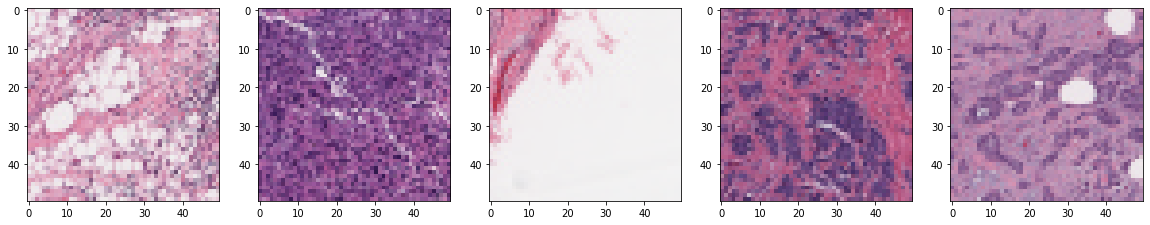

In [7]:
fig, ax = plt.subplots(1,5,figsize=(20,10))

for m in range(5):
    idx = pos_selection[m]
    image = imread(data.loc[idx, "path"])
    ax[m].imshow(image)
    ax[m].grid(False)

In [6]:
patients = data.patient_id.unique()

# 70% 15% 15% split
train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, val_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [10]:
print(len(train_ids), len(val_ids), len(test_ids))

195 42 42


In [7]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
val_df = data.loc[data.patient_id.isin(val_ids),:].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Negative vs Positive')

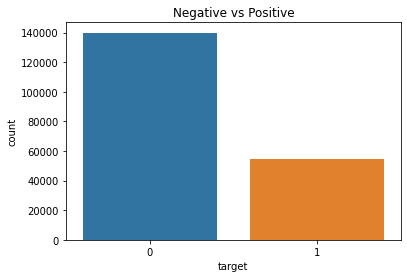

In [9]:
sns.countplot(train_df.target)
plt.title("Negative vs Positive")

In [14]:
count = train_df.target.value_counts()
print(count)

0    139949
1     54597
Name: target, dtype: int64


There is a big imbalance between the two classes. We need to resample the training dataset (ONLY the training, because we don't want to mess with the validation data and introduce bias.)

In [10]:
WIDTH = 50
HEIGHT = 50
X_train = []
# Pick less data, because ram 
for img in train_df['path']:
    full_size_image = cv2.imread(img)
    X_train.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

In [11]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(train_df['target']).astype(np.float32)
print(X_train.shape)
print(y_train)

(194546, 50, 50, 3)
[0. 0. 0. ... 1. 1. 1.]


In [12]:
X_train_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_train_flat = X_train.reshape(X_train.shape[0],X_train_shape)

In [13]:
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(ratio='auto')
rus = RandomUnderSampler(ratio='auto')
X_rus,y_rus= rus.fit_resample(X_train_flat,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
y_val = np.array(val_df['target'])
y_test = np.array(test_df['target'])
print(y_val.shape)
print(y_test.shape)

(38660,)
(44318,)


In [15]:
y_train_hot = to_categorical(y_rus, num_classes = 2)

In [16]:
val_df[['negative','positive']] = to_categorical(y_val, num_classes = 2)
test_df[['negative','positive']] = to_categorical(y_test, num_classes = 2)

In [27]:
val_df.head()

,patient_id,path,target,negative,positive
6908,10292,/content/data/IDC_regular_ps50_idx5/10292/0/10...,0,1.0,0.0
6909,10292,/content/data/IDC_regular_ps50_idx5/10292/0/10...,0,1.0,0.0
6910,10292,/content/data/IDC_regular_ps50_idx5/10292/0/10...,0,1.0,0.0
6911,10292,/content/data/IDC_regular_ps50_idx5/10292/0/10...,0,1.0,0.0
6912,10292,/content/data/IDC_regular_ps50_idx5/10292/0/10...,0,1.0,0.0


In [17]:
height, width, channels = 50,50,3
for i in range(len(X_rus)):
    X_train_reshaped = X_rus.reshape(len(X_rus),height,width,channels)
X_train_reshaped.shape

(109194, 50, 50, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Negative vs Positive')

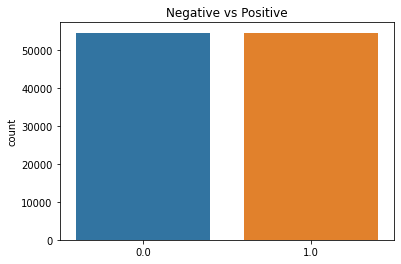

In [29]:
sns.countplot(y_rus)
plt.title("Negative vs Positive")

In [19]:
# Delete old variables to free ram space
for element in ['X_train','X_train_flat','X_rus','train_df','y_rus','y_test','y_train','y_val']:
  del globals()[element]
del element  

In [20]:
# Some hyper-parameters:
img_height = 50
img_width =  50  
input_shape = (img_height, img_width, 3) #resize the input images to this shape
batch_size  = 128        # Images per batch 
num_epochs  = 10      # Max number of training epochs

# Number of classes:
num_classes = 2

#CNN

In [28]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 50, 50, 64)        1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)              

In [29]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [30]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [31]:
generator = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=90)

train_generator = generator.flow(X_train_reshaped, 
                                 y_train_hot,     
                                 batch_size=batch_size)   
               
val_generator = generator.flow_from_dataframe(dataframe=val_df,
                                                x_col="path",
                                                y_col=["negative","positive"],
                                                class_mode="raw",
                                                target_size = (img_height,img_width),                   
                                                batch_size=batch_size)

test_generator = generator.flow_from_dataframe(dataframe=test_df,
                                                x_col="path",
                                                y_col=["negative","positive"],
                                                class_mode="raw",
                                                target_size = (img_height,img_width),                   
                                                batch_size=batch_size,
                                                shuffle=False)

Found 38660 validated image filenames.
Found 44318 validated image filenames.


In [32]:
logdir = os.path.join("./logs/CNN", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [33]:
#save best model
filepath = './models/CNN.h5'
callbacks = [ModelCheckpoint(filepath, monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=len(y_train_hot)//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/10
853/853 [==============================] - 127s 147ms/step - loss: 0.4862 - accuracy: 0.7853 - precision_1: 0.7853 - recall_1: 0.7853 - f1_score: 0.7853 - val_loss: 0.9902 - val_accuracy: 0.4903 - val_precision_1: 0.4903 - val_recall_1: 0.4903 - val_f1_score: 0.4903
Epoch 2/10
853/853 [==============================] - 110s 129ms/step - loss: 0.3836 - accuracy: 0.8342 - precision_1: 0.8342 - recall_1: 0.8342 - f1_score: 0.8341 - val_loss: 0.6159 - val_accuracy: 0.7880 - val_precision_1: 0.7880 - val_recall_1: 0.7880 - val_f1_score: 0.7880
Epoch 3/10
853/853 [==============================] - 110s 129ms/step - loss: 0.3719 - accuracy: 0.8387 - precision_1: 0.8387 - recall_1: 0.8387 - f1_score: 0.8383 - val_loss: 2.6903 - val_accuracy: 0.2820 - val_precision_1: 0.2820 - val_recall_1: 0.2820 - val_f1_score: 0.2820
Epoch 4/10
853/853 [==============================] - 109s 128ms/step - loss: 0.3617 - accuracy: 0.8455 - precision_1: 0.8455 - recall_1: 0.8455 - f1_score: 0.8454 - 

In [ ]:
%tensorboard --logdir logs/CNN

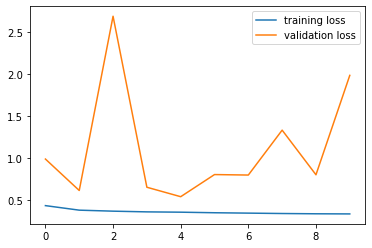

In [35]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

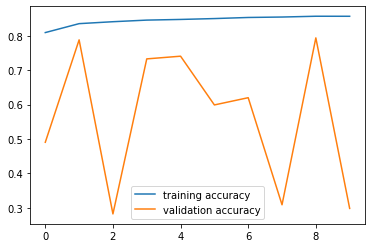

In [36]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [37]:
model = load_model('./models/CNN.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

347/347 [==============================] - 59s 169ms/step - loss: 0.6639 - accuracy: 0.7419 - precision_2: 0.7419 - recall_2: 0.7419 - f1_score: 0.7419
Test loss:  0.6508168578147888
Test accuracy: 0.7563969492912292
Test precision: 0.7563969492912292
Test recall: 0.7563969492912292
Test f1_score: 0.7567872405052185


Text(0.5, 33.0, 'Predicted label')

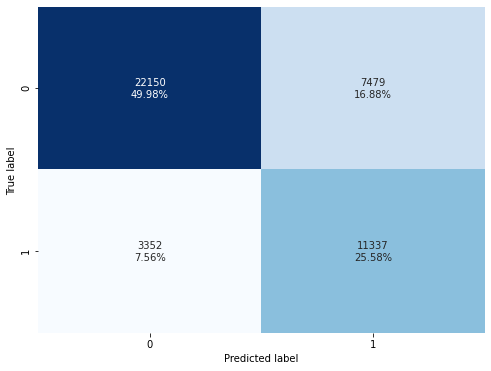

In [50]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
# y_test = test_generator.labels
y_test = test_df.target.to_numpy().astype(np.int)

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# ResNet-50

In [63]:
from keras.applications import ResNet50

In [64]:
baseModel = ResNet50(weights=None, include_top=False,
	input_tensor=Input(shape=(img_height, img_width, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(num_classes, num_classes))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [65]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [66]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [67]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [68]:
generator = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=90)

train_generator = generator.flow(X_train_reshaped, 
                                 y_train_hot,     
                                 batch_size=batch_size)   
               
val_generator = generator.flow_from_dataframe(dataframe=val_df,
                                                x_col="path",
                                                y_col=["negative","positive"],
                                                class_mode="raw",
                                                target_size = (img_height,img_width),                   
                                                batch_size=batch_size)

test_generator = generator.flow_from_dataframe(dataframe=test_df,
                                                x_col="path",
                                                y_col=["negative","positive"],
                                                class_mode="raw",
                                                target_size = (img_height,img_width),                   
                                                batch_size=batch_size,
                                                shuffle=False)

Found 38660 validated image filenames.
Found 44318 validated image filenames.


In [71]:
logdir = os.path.join("./logs/ResNet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [72]:
#save best model
filepath = './models/ResNet.h5'
callbacks = [ModelCheckpoint(filepath, monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=len(y_train_hot)//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/10
853/853 [==============================] - 166s 195ms/step - loss: 0.4077 - accuracy: 0.8219 - precision_3: 0.8219 - recall_3: 0.8219 - f1_score: 0.8221 - val_loss: 0.5389 - val_accuracy: 0.8482 - val_precision_3: 0.8482 - val_recall_3: 0.8482 - val_f1_score: 0.8482
Epoch 2/10
853/853 [==============================] - 164s 192ms/step - loss: 0.3802 - accuracy: 0.8360 - precision_3: 0.8360 - recall_3: 0.8360 - f1_score: 0.8360 - val_loss: 0.7522 - val_accuracy: 0.7745 - val_precision_3: 0.7745 - val_recall_3: 0.7745 - val_f1_score: 0.7745
Epoch 3/10
853/853 [==============================] - 163s 191ms/step - loss: 0.3623 - accuracy: 0.8447 - precision_3: 0.8447 - recall_3: 0.8447 - f1_score: 0.8448 - val_loss: 0.4903 - val_accuracy: 0.8250 - val_precision_3: 0.8250 - val_recall_3: 0.8250 - val_f1_score: 0.8250
Epoch 4/10
853/853 [==============================] - 163s 191ms/step - loss: 0.3526 - accuracy: 0.8507 - precision_3: 0.8507 - recall_3: 0.8507 - f1_score: 0.8507 - 

In [ ]:
%tensorboard --logdir logs/ResNet

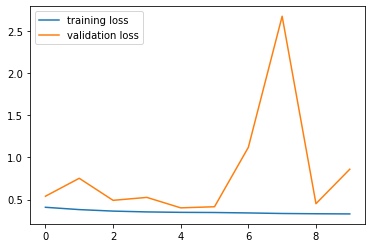

In [74]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

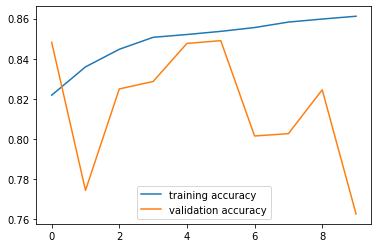

In [75]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [76]:
model = load_model('./models/ResNet.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

347/347 [==============================] - 51s 142ms/step - loss: 0.4619 - accuracy: 0.8305 - precision_4: 0.8305 - recall_4: 0.8305 - f1_score: 0.8305
Test loss:  0.4637153744697571
Test accuracy: 0.8362967371940613
Test precision: 0.8362967371940613
Test recall: 0.8362967371940613
Test f1_score: 0.8361430168151855


Text(0.5, 33.0, 'Predicted label')

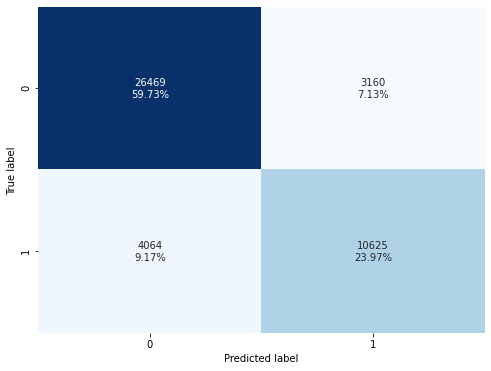

In [77]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
# y_test = test_generator.labels
y_test = test_df.target.to_numpy().astype(np.int)

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')